<a href="https://colab.research.google.com/github/CY-chang/Brain-Signal-Classification/blob/main/brain_signal_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

(optional)

In [1]:
from google.colab import drive
import os

In [2]:
os.chdir('/content/drive/MyDrive')


# **HW5: Brain signal classification**
In *HW 5*, you need to finish:

1.  Model Implementation Part: Implement LSTM and EEGNet models to predict the label of each samples.

2.  Model Competition Part: Implementing a model to reach better accuracy performance.

In [3]:
import numpy as np
import os
import math
import csv
import matplotlib.pyplot as plt
# Import the packages you need here

import tensorflow as tf
from tensorflow.keras import layers, models, activations
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential


In [4]:
data = np.load('data.npz')
label = np.load('label.npz')


In [5]:
X_train = data['X_train']
X_val = data['X_val']
X_test = data['X_test']

Y_train = label['Y_train']
Y_val = label['Y_val']

In [6]:
X_train.shape, X_val.shape, X_test.shape

((604, 22, 200), (152, 22, 200), (190, 22, 200))

In [7]:
Y_train.shape, Y_val.shape

((604, 1), (152, 1))

## Model Implementation Part

### LSTM

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200)               320800    
                                                                 
 dense (Dense)               (None, 6)                 1206      
                                                                 
Total params: 322006 (1.23 MB)
Trainable params: 322006 (1.23 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
19/19 [==============================] - 9s 234ms/step - loss: 1.2301 - accuracy: 0.4983 - val_loss: 0.9206 - val_accuracy: 0.6250
Epoch 2/10
19/19 [==============================] - 2s 111ms/step - loss: 0.6010 - accuracy: 0.8129 - val_loss: 0.7514 - val_accuracy: 0.7105
Epoch 3/10
19/19 [==============================] - 2s 90ms/step - loss: 0.3163 - accuracy: 0.9570 - val_loss: 0.6470 - val_accuracy

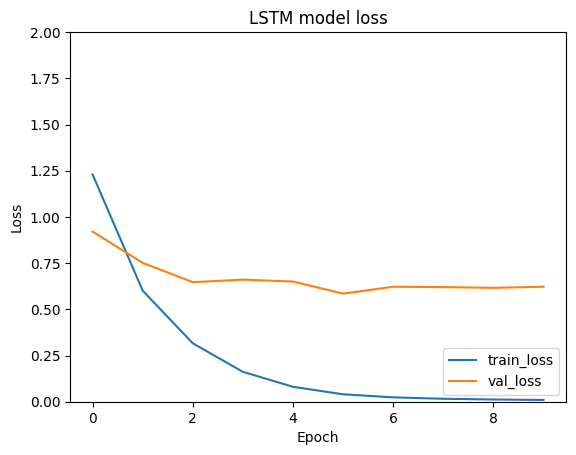

In [8]:
# Build your model here:
model = Sequential()
#model.add(layers.Embedding(200, 10, input_length=22))
model.add(tf.keras.Input(shape=(22, 200)))
model.add(layers.LSTM(200))
model.add(layers.Dense(6))

model.summary()

model.compile(tf.keras.optimizers.Adam(learning_rate = 1e-3),
       loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
       metrics=['accuracy'])
history = model.fit(X_train, Y_train, epochs=10,
           validation_data=(X_val, Y_val))

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 2])
plt.title('LSTM model loss')
plt.legend(loc='lower right')
test_loss, test_acc = model.evaluate(X_val, Y_val, verbose=2)

print(test_acc)

In [9]:
pred_test = model.predict(X_test)
output = np.argmax(pred_test, axis = 1)
output = output.reshape((190, 1))

assert(output.shape == (190, 1))
np.savetxt('lstm_output.csv', output, delimiter=",")

6/6 [==============================] - 1s 18ms/step


### EEGNet

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 22, 200, 1)        0         
                                                                 
 conv2d (Conv2D)             (None, 22, 200, 8)        520       
                                                                 
 batch_normalization (Batch  (None, 22, 200, 8)        32        
 Normalization)                                                  
                                                                 
 depthwise_conv2d (Depthwis  (None, 1, 200, 16)        368       
 eConv2D)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 1, 200, 16)        64        
 chNormalization)                                                
                                                      

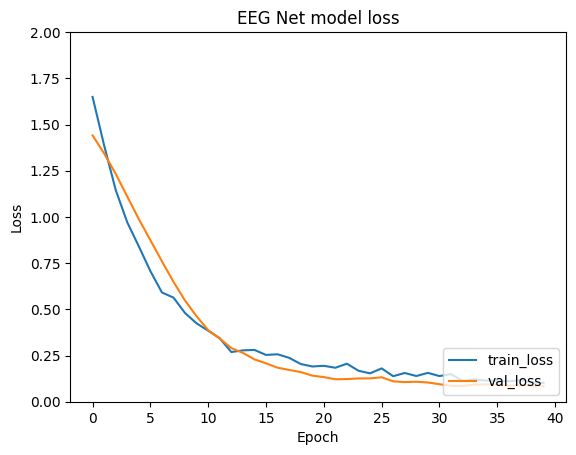

In [10]:
# Build your model here:

D = 2
F1 = 8
F2 = 16
C = 22 #number of channels
p = 0.5 # dropout rate
N = 6 #number of classes
T = 200 # number of time points
model = Sequential()

#block1
model.add(layers.Reshape((C, T, 1), input_shape=(C, T)))
model.add(layers.Conv2D(F1, (1, 64), activation='linear', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.DepthwiseConv2D((C, 1), padding='valid', depth_multiplier=D, depthwise_constraint=tf.keras.constraints.MaxNorm(max_value=1)))
model.add(layers.BatchNormalization())
model.add(layers.Activation(activations.elu))
model.add(layers.AveragePooling2D((1, 4)))
model.add(Dropout(p))

#block2
model.add(layers.SeparableConv2D(filters=F2, kernel_size=(1, 16), padding='same', activation='linear'))
model.add(layers.BatchNormalization())
model.add(layers.Activation(activations.elu))
model.add(layers.AveragePooling2D((1, 8)))
model.add(Dropout(p))
model.add(layers.Flatten())

model.add(layers.Dense(units=6, activation='softmax', kernel_constraint=tf.keras.constraints.MaxNorm(max_value=2)))

model.summary()


model.compile(tf.keras.optimizers.Adam(learning_rate = 1e-3),
       loss=tf.keras.losses.SparseCategoricalCrossentropy(),
       metrics=['accuracy'])
history = model.fit(X_train, Y_train, epochs=40,
           validation_data=(X_val, Y_val))

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 2])
plt.title('EEG Net model loss')
plt.legend(loc='lower right')
test_loss, test_acc = model.evaluate(X_val, Y_val, verbose=2)

print(test_acc)



In [11]:
pred_test = model.predict(X_test)
output = np.argmax(pred_test, axis = 1)
output = output.reshape((190, 1))

assert(output.shape == (190, 1))
np.savetxt('eegnet_output.csv', output, delimiter=",")

6/6 [==============================] - 0s 41ms/step


## Model Competition Part

In [12]:
#output = "..."
assert(output.shape == (190, 1))
np.savetxt('competition_output.csv', output, delimiter=",")